In [1]:
import requests
import torch
from PIL import Image
from transformers import *
from tqdm import tqdm
#Используем видеокарту
device = "cuda"

c:\code\anaconda3\envs\transaltion\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\code\anaconda3\envs\transaltion\Lib\site-packages\transformers\deepspeed.py:24: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from timm import create_model, list_models
from types import SimpleNamespace
from transformers import GPT2LMHeadModel, GPT2TokenizerFast, get_linear_schedule_with_warmup
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
from pathlib import Path
from sklearn.model_selection import train_test_split
from torch.cuda.amp import GradScaler, autocast
from tqdm.auto import tqdm
import gc
import json

c:\code\anaconda3\envs\transaltion\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
sample_tfms = [
    A.HorizontalFlip(),
    A.RandomBrightnessContrast(),
    A.ColorJitter(),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.3, rotate_limit=45, p=0.5),
    A.HueSaturationValue(p=0.3),
]
train_tfms = A.Compose([
    *sample_tfms,
    A.Resize(224,224),
    A.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5],always_apply=True),
    ToTensorV2()
])
valid_tfms = A.Compose([
    A.Resize(224,224),
    A.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5],always_apply=True),
    ToTensorV2()
])

c:\code\anaconda3\envs\transaltion\Lib\site-packages\albumentations\core\validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
C:\Users\Тимур\AppData\Local\Temp\ipykernel_28604\3943366170.py:11: UserWarning: Argument(s) 'always_apply' are not valid for transform Normalize
  A.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5],always_apply=True),
C:\Users\Тимур\AppData\Local\Temp\ipykernel_28604\3943366170.py:16: UserWarning: Argument(s) 'always_apply' are not valid for transform Normalize
  A.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5],always_apply=True),


In [4]:
encoder_model = "microsoft/swin-base-patch4-window7-224-in22k"
decoder_model = "ai-forever/rugpt3small_based_on_gpt2"
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    encoder_model, decoder_model
).to(device)
tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')

loading configuration file config.json from cache at C:\Users\Тимур\.cache\huggingface\hub\models--microsoft--swin-base-patch4-window7-224-in22k\snapshots\68dc76680a5bf3bdf670669f3025dc9be2e30781\config.json
Model config SwinConfig {
  "_name_or_path": "microsoft/swin-base-patch4-window7-224-in22k",
  "architectures": [
    "SwinForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "depths": [
    2,
    2,
    18,
    2
  ],
  "drop_path_rate": 0.1,
  "embed_dim": 128,
  "encoder_stride": 32,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "id2label": {
    "0": "organism, being",
    "1": "benthos",
    "2": "heterotroph",
    "3": "cell",
    "4": "person, individual, someone, somebody, mortal, soul",
    "5": "animal, animate_being, beast, brute, creature, fauna",
    "6": "plant, flora, plant_life",
    "7": "food, nutrient",
    "8": "artifact, artefact",
    "9": "hop",
    "10": "check-in",
    "11": "dressage",
    "12": "curvet, 

In [5]:
tokenizer = GPT2TokenizerFast.from_pretrained(decoder_model)
image_processor = ViTImageProcessor.from_pretrained(encoder_model)

loading file vocab.json from cache at C:\Users\Тимур\.cache\huggingface\hub\models--ai-forever--rugpt3small_based_on_gpt2\snapshots\a9307e696cd3c5b7f953ff4cb19d76a4d81821d5\vocab.json
loading file merges.txt from cache at C:\Users\Тимур\.cache\huggingface\hub\models--ai-forever--rugpt3small_based_on_gpt2\snapshots\a9307e696cd3c5b7f953ff4cb19d76a4d81821d5\merges.txt
loading file tokenizer.json from cache at None
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at C:\Users\Тимур\.cache\huggingface\hub\models--ai-forever--rugpt3small_based_on_gpt2\snapshots\a9307e696cd3c5b7f953ff4cb19d76a4d81821d5\special_tokens_map.json
loading file tokenizer_config.json from cache at C:\Users\Тимур\.cache\huggingface\hub\models--ai-forever--rugpt3small_based_on_gpt2\snapshots\a9307e696cd3c5b7f953ff4cb19d76a4d81821d5\tokenizer_config.json
loading configuration file preprocessor_config.json from cache at C:\Users\Тимур\.cache\huggingface\hub\models--microso

In [5]:
tokenizer.encode_plus('hello! this is a caption')

{'input_ids': [31373, 0, 428, 318, 257, 8305], 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [6]:
tokenizer = GPT2TokenizerFast.from_pretrained(decoder_model)
image_processor = ViTImageProcessor.from_pretrained(encoder_model)

loading file vocab.json from cache at C:\Users\Тимур\.cache\huggingface\hub\models--ai-forever--rugpt3small_based_on_gpt2\snapshots\a9307e696cd3c5b7f953ff4cb19d76a4d81821d5\vocab.json
loading file merges.txt from cache at C:\Users\Тимур\.cache\huggingface\hub\models--ai-forever--rugpt3small_based_on_gpt2\snapshots\a9307e696cd3c5b7f953ff4cb19d76a4d81821d5\merges.txt
loading file tokenizer.json from cache at None
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at C:\Users\Тимур\.cache\huggingface\hub\models--ai-forever--rugpt3small_based_on_gpt2\snapshots\a9307e696cd3c5b7f953ff4cb19d76a4d81821d5\special_tokens_map.json
loading file tokenizer_config.json from cache at C:\Users\Тимур\.cache\huggingface\hub\models--ai-forever--rugpt3small_based_on_gpt2\snapshots\a9307e696cd3c5b7f953ff4cb19d76a4d81821d5\tokenizer_config.json
loading configuration file preprocessor_config.json from cache at C:\Users\Тимур\.cache\huggingface\hub\models--microso

In [7]:
# set the decoder start token id to the CLS token id of the tokenizer
model.config.decoder_start_token_id = tokenizer.bos_token_id
# set the pad token id to the pad token id of the tokenizer
model.config.pad_token_id = tokenizer.pad_token_id

In [19]:
import evaluate
rouge = evaluate.load("rouge")
bleu = evaluate.load("bleu")
meteor = evaluate.load("meteor")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    # all unnecessary tokens are removed
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    rouge_output = rouge.compute(predictions=pred_str, references=label_str)
    meteor_otput = meteor.compute(predictions=pred_str, references=label_str)
    bleu_otput = bleu.compute(predictions=pred_str, references=label_str)
    return {
        "rouge": round(rouge_output['rouge1'], 4),
        "meteor": round(meteor_otput['meteor'], 4),
        "bleu": round(bleu_otput['bleu'], 4),
    }

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Тимур\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Тимур\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Тимур\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Датасет

In [8]:
import pandas as pd

In [11]:
train_df = pd.read_parquet('train.parquet')
val_df = pd.read_parquet('val.parquet')

In [10]:
from sklearn.model_selection import train_test_split
df = pd.read_parquet("captions.parquet")[['image_name', 'rus_cap']]
df = df[df['rus_cap'].map(len) < 100]
train_df , val_df = train_test_split(df , test_size = 0.2)
train_df.head()

image_name                                            rus_cap
156205  8209386413.jpg  Маленький ребенок около восьми лет сидит на ве...
84195    374437796.jpg  Группа женщин окружает девушку с букетом цвето...
99400   4448092863.jpg  Шесть женщин в черных куртках и ярко-красных б...
65690   3328337417.jpg  Несколько человек позируют для фото через раму...
45100   2834103050.jpg  Люди, одетые в купальные костюмы, платья и шор...

In [4]:
train_df.to_parquet('train.parquet')
val_df.to_parquet('val.parquet')

In [10]:
len(train_df)

17557

In [35]:
train_df = train_df.sample(32)
val_df = val_df.sample(8)

In [12]:
max_length=50
import os
class Dataset:
    def __init__(self, df, tfms, root_dir='1/flickr30k_images'):
        self.df = df
        self.tfms = tfms
        self.root_dir = root_dir
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        sample = self.df.iloc[idx,:]
        image = sample['image_name']
        caption = sample['rus_cap']
        image = os.path.join(self.root_dir, image)
        image = Image.open(image).convert('RGB')
        image = np.array(image)
        augs = self.tfms(image=image)
        pixel_values = augs['image']
        captions = tokenizer(caption, max_length=max_length, padding="max_length", truncation=True, return_tensors="pt").input_ids
        captions = [caption if caption != tokenizer.pad_token_id else -100 for caption in captions[0]]
        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(captions)}
        return encoding

In [13]:
train_ds = Dataset(train_df,train_tfms)
val_ds = Dataset(val_df,valid_tfms)

In [14]:
num_epochs = 5# number of epochs
batch_size = 8 # the size of batches

In [22]:
for item in train_ds:
  print(item["labels"].shape)
  print(item["pixel_values"].shape)
  break

torch.Size([50])
torch.Size([3, 224, 224])


In [23]:
# define the training arguments
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,             # use generate to calculate the loss
    num_train_epochs=num_epochs,            # number of epochs
    evaluation_strategy="steps",            # evaluate after each eval_steps
    eval_steps=3148,                        # evaluate after each 2000 steps
    logging_steps=3148,                     # log after each 2000 steps
    save_steps=3148,                        # save after each 2000 steps
    per_device_train_batch_size=batch_size, # batch size for training
    per_device_eval_batch_size=batch_size,  # batch size for evaluation
    output_dir="captioningv2.1", # output directory
    # push_to_hub=True # whether you want to push the model to the hub,
    # check this guide for more details: https://huggingface.co/transformers/model_sharing.html
)

c:\code\anaconda3\envs\transaltion\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [24]:
#model = VisionEncoderDecoderModel.from_pretrained(r"Vit_ru_gpt2").to(device)

In [25]:
tokenizer = GPT2TokenizerFast.from_pretrained('ai-forever/rugpt3small_based_on_gpt2')

loading file vocab.json from cache at C:\Users\Тимур\.cache\huggingface\hub\models--ai-forever--rugpt3small_based_on_gpt2\snapshots\a9307e696cd3c5b7f953ff4cb19d76a4d81821d5\vocab.json
loading file merges.txt from cache at C:\Users\Тимур\.cache\huggingface\hub\models--ai-forever--rugpt3small_based_on_gpt2\snapshots\a9307e696cd3c5b7f953ff4cb19d76a4d81821d5\merges.txt
loading file tokenizer.json from cache at None
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at C:\Users\Тимур\.cache\huggingface\hub\models--ai-forever--rugpt3small_based_on_gpt2\snapshots\a9307e696cd3c5b7f953ff4cb19d76a4d81821d5\special_tokens_map.json
loading file tokenizer_config.json from cache at C:\Users\Тимур\.cache\huggingface\hub\models--ai-forever--rugpt3small_based_on_gpt2\snapshots\a9307e696cd3c5b7f953ff4cb19d76a4d81821d5\tokenizer_config.json


In [26]:
# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,                     # the instantiated 🤗 Transformers model to be trained
    tokenizer=image_processor,       # we use the image processor as the tokenizer
    args=training_args,              # pass the training arguments
    compute_metrics=compute_metrics, 
    train_dataset=train_ds,     
    eval_dataset=val_ds       
)

In [27]:
trainer.train()

***** Running training *****
  Num examples = 17,557
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 10,975
  Number of trainable parameters = 241,128,888
 29%|██▊       | 3148/10975 [20:42<52:38,  2.48it/s]  
***** Running Evaluation *****
  Num examples = 4390
  Batch size = 8


{'loss': 2.5083, 'grad_norm': 5.4486470222473145, 'learning_rate': 3.565831435079727e-05, 'epoch': 1.43}


c:\code\anaconda3\envs\transaltion\Lib\site-packages\transformers\generation\utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
                                                    
 29%|██▊       | 3148/10975 [25:36<52:38,  2.48it/s]Saving model checkpoint to captioningv2.1\checkpoint-3148
Configuration saved in captioningv2.1\checkpoint-3148\config.json
Configuration saved in captioningv2.1\checkpoint-3148\generation_config.json


{'eval_loss': 2.4031782150268555, 'eval_rouge': 0.0003, 'eval_meteor': 0.1436, 'eval_bleu': 0.0225, 'eval_runtime': 293.8209, 'eval_samples_per_second': 14.941, 'eval_steps_per_second': 1.868, 'epoch': 1.43}


Model weights saved in captioningv2.1\checkpoint-3148\model.safetensors
Image processor saved in captioningv2.1\checkpoint-3148\preprocessor_config.json
 57%|█████▋    | 6296/10975 [45:49<29:29,  2.64it/s]    
***** Running Evaluation *****
  Num examples = 4390
  Batch size = 8
c:\code\anaconda3\envs\transaltion\Lib\site-packages\transformers\generation\utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


{'loss': 1.8894, 'grad_norm': 6.698065280914307, 'learning_rate': 2.1316628701594536e-05, 'epoch': 2.87}


                                                    
 57%|█████▋    | 6296/10975 [51:14<29:29,  2.64it/s]Saving model checkpoint to captioningv2.1\checkpoint-6296
Configuration saved in captioningv2.1\checkpoint-6296\config.json


{'eval_loss': 2.3764731884002686, 'eval_rouge': 0.0002, 'eval_meteor': 0.1459, 'eval_bleu': 0.017, 'eval_runtime': 324.391, 'eval_samples_per_second': 13.533, 'eval_steps_per_second': 1.692, 'epoch': 2.87}


Configuration saved in captioningv2.1\checkpoint-6296\generation_config.json
Model weights saved in captioningv2.1\checkpoint-6296\model.safetensors
Image processor saved in captioningv2.1\checkpoint-6296\preprocessor_config.json
 86%|████████▌ | 9444/10975 [1:13:49<10:48,  2.36it/s]  
***** Running Evaluation *****
  Num examples = 4390
  Batch size = 8
c:\code\anaconda3\envs\transaltion\Lib\site-packages\transformers\generation\utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


{'loss': 1.4123, 'grad_norm': 8.157041549682617, 'learning_rate': 6.9749430523918e-06, 'epoch': 4.3}


                                                      
 86%|████████▌ | 9444/10975 [1:19:53<10:48,  2.36it/s]Saving model checkpoint to captioningv2.1\checkpoint-9444
Configuration saved in captioningv2.1\checkpoint-9444\config.json


{'eval_loss': 2.5696310997009277, 'eval_rouge': 0.0003, 'eval_meteor': 0.1167, 'eval_bleu': 0.0123, 'eval_runtime': 363.5171, 'eval_samples_per_second': 12.076, 'eval_steps_per_second': 1.51, 'epoch': 4.3}


Configuration saved in captioningv2.1\checkpoint-9444\generation_config.json
Model weights saved in captioningv2.1\checkpoint-9444\model.safetensors
Image processor saved in captioningv2.1\checkpoint-9444\preprocessor_config.json
100%|██████████| 10975/10975 [1:30:52<00:00,  2.62it/s]   Saving model checkpoint to captioningv2.1\checkpoint-10975
Configuration saved in captioningv2.1\checkpoint-10975\config.json
Configuration saved in captioningv2.1\checkpoint-10975\generation_config.json
Model weights saved in captioningv2.1\checkpoint-10975\model.safetensors
Image processor saved in captioningv2.1\checkpoint-10975\preprocessor_config.json


Training completed. Do not forget to share your model on huggingface.co/models =)


100%|██████████| 10975/10975 [1:30:56<00:00,  2.01it/s]

{'train_runtime': 5456.9944, 'train_samples_per_second': 16.087, 'train_steps_per_second': 2.011, 'train_loss': 1.8327162229498861, 'epoch': 5.0}


TrainOutput(global_step=10975, training_loss=1.8327162229498861, metrics={'train_runtime': 5456.9944, 'train_samples_per_second': 16.087, 'train_steps_per_second': 2.011, 'total_flos': 1.5932500367956623e+19, 'train_loss': 1.8327162229498861, 'epoch': 5.0})

In [23]:
model = VisionEncoderDecoderModel.from_pretrained(r"captioningv2.1/checkpoint-9444").to(device)

loading configuration file captioningv2.1/checkpoint-9444\config.json
Model config VisionEncoderDecoderConfig {
  "architectures": [
    "VisionEncoderDecoderModel"
  ],
  "decoder": {
    "_name_or_path": "ai-forever/rugpt3small_based_on_gpt2",
    "activation_function": "gelu_new",
    "add_cross_attention": true,
    "architectures": [
      "GPT2LMHeadModel"
    ],
    "attn_pdrop": 0.1,
    "bad_words_ids": null,
    "begin_suppress_tokens": null,
    "bos_token_id": 1,
    "chunk_size_feed_forward": 0,
    "cross_attention_hidden_size": null,
    "decoder_start_token_id": null,
    "diversity_penalty": 0.0,
    "do_sample": false,
    "early_stopping": false,
    "embd_pdrop": 0.1,
    "encoder_no_repeat_ngram_size": 0,
    "eos_token_id": 2,
    "exponential_decay_length_penalty": null,
    "finetuning_task": null,
    "forced_bos_token_id": null,
    "forced_eos_token_id": null,
    "gradient_checkpointing": false,
    "id2label": {
      "0": "LABEL_0"
    },
    "initializer_

In [33]:
q = val_df.sample(1)

In [34]:
print(q['image_name'], q['rus_cap'])

81030    3666537170.jpg
Name: image_name, dtype: object 81030    Мальчик в оранжевых и белых плавках падает в в...
Name: rus_cap, dtype: object


In [35]:
q['rus_cap'].tolist()

['Мальчик в оранжевых и белых плавках падает в воду на пляже или озере.']

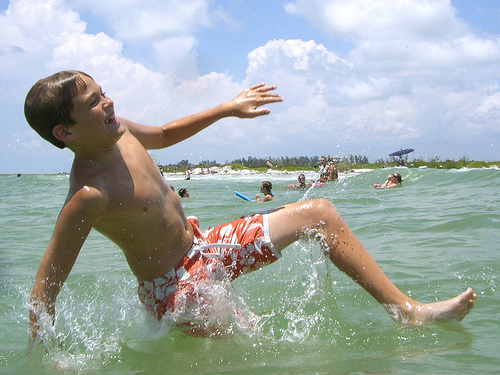

In [36]:
img =  Image.open("1/flickr30k_images/3666537170.jpg").convert("RGB")
img

In [38]:
generated_caption = tokenizer.decode(model.generate(image_processor(img, return_tensors="pt").pixel_values.to("cuda"), no_repeat_ngram_size=2, num_beams=5, early_stopping=True, max_length=25, repetition_penalty=1.5)[0])
print(generated_caption)

<s>
Мальчик в красных купальнике находится в воде на пляже рядом с пляжем. 😊Ребенок в


In [ ]:
model.save_pretrained("swin_ru_gpt2") 

Configuration saved in Vit_ru_gpt2\config.json
Configuration saved in Vit_ru_gpt2\generation_config.json
Model weights saved in Vit_ru_gpt2\model.safetensors


In [503]:
q = val_df.sample(1)

In [508]:
print(q['image_name'], q['rus_cap'])

138260    5793396150.jpg
Name: image_name, dtype: object 138260    Полицейский ездит верхом на своей лошади по го...
Name: rus_cap, dtype: object


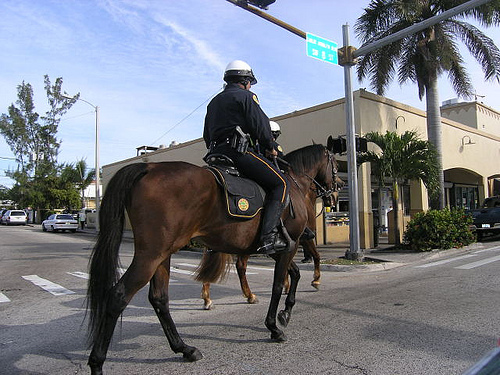

In [512]:
img =  Image.open("1/flickr30k_images/5793396150.jpg").convert("RGB")
img

In [513]:
generated_caption = tokenizer.decode(model.generate(image_processor(img, return_tensors="pt").pixel_values.to("cuda"))[0], max_length=100)
print('\033[96m' +generated_caption)

<s> Человек в черной шляпе верхом на коричневом коне с черным шлемом, черной рубашкой с


In [ ]:
model.set   

<bound method Module.parameters of VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
  

In [132]:
q = val_df.sample(1)

In [133]:
print(q['image_name'], q['rus_cap'])

50625    2970827076.jpg
Name: image_name, dtype: object 50625    Мужчина ждет дела за прилавком туристического ...
Name: rus_cap, dtype: object


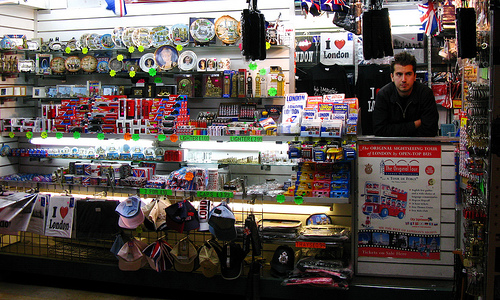

In [49]:
img =  Image.open("1/flickr30k_images/2970827076.jpg").convert("RGB")
img

In [50]:
generated_caption = tokenizer.decode(model.generate(image_processor(img, return_tensors="pt").pixel_values.to("cuda"))[0])
print('\033[96m' +generated_caption[:250]+ '\033[0m')

<s>зиатский мужчина стоит за прилавком, продающим конфеты в том, что кажется комической интерпрета


In [150]:
q = df.sample(1)

In [151]:
print(q['image_name'], q['rus_cap'])

3690    1246239396.jpg
Name: image_name, dtype: object 3690    Человек в белом фартуке сидит за столом с едой...
Name: rus_cap, dtype: object


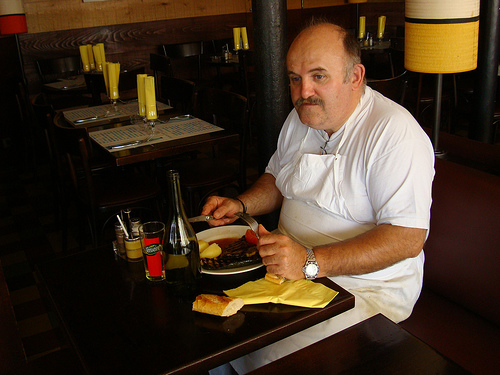

In [152]:
img =  Image.open("1/flickr30k_images/1246239396.jpg").convert("RGB")
img

In [153]:
generated_caption = tokenizer.decode(model.generate(image_processor(img, return_tensors="pt").pixel_values.to("cuda"))[0])
print('\033[96m' +generated_caption[:200]+ '\033[0m')

<s> наруж белом фартуке сидит за столом с едой, рядом сожилым мужчиной в белой рубашке


In [155]:
model.save_pretrained("Vit_ru_gpt2") 

Configuration saved in Vit_ru_gpt2\config.json
Configuration saved in Vit_ru_gpt2\generation_config.json
Model weights saved in Vit_ru_gpt2\model.safetensors


In [39]:
all_df = pd.read_parquet("captions.parquet")

In [42]:
import evaluate

In [43]:
meteor_score = evaluate.load('meteor')
bleu_score = evaluate.load('bleu')
rouge_score = evaluate.load('rouge')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Тимур\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Тимур\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Тимур\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [44]:
from nltk.tokenize import word_tokenize

def word_tokenize_rus(text):
    return word_tokenize(text.lower(), language='russian')

In [45]:
def eval_cap(model_name, result, original_texts):
    list_ref = [[ref] for ref in original_texts]
    bleu_results = bleu_score.compute(references=list_ref, predictions=result, tokenizer=word_tokenize_rus)
    rouge_results = rouge_score.compute(references=list_ref, predictions=result, tokenizer=word_tokenize_rus)
    meteor_results = meteor_score.compute(references=list_ref, predictions=result)
    return {'model': model_name, 'bleu': bleu_results['bleu'], 'meteor': meteor_results['meteor'],
            'rouge1': rouge_results['rouge1'], 'rouge2': rouge_results['rouge2'], 'rougeL': rouge_results['rougeL']}

In [ ]:
generated_caption = tokenizer.decode(model.generate(image_processor(img, return_tensors="pt").pixel_values.to("cuda"))[0])

In [46]:
model.eval()

VisionEncoderDecoderModel(
  (encoder): SwinModel(
    (embeddings): SwinEmbeddings(
      (patch_embeddings): SwinPatchEmbeddings(
        (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): SwinEncoder(
      (layers): ModuleList(
        (0): SwinStage(
          (blocks): ModuleList(
            (0-1): 2 x SwinLayer(
              (layernorm_before): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attention): SwinAttention(
                (self): SwinSelfAttention(
                  (query): Linear(in_features=128, out_features=128, bias=True)
                  (key): Linear(in_features=128, out_features=128, bias=True)
                  (value): Linear(in_features=128, out_features=128, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )
                (output): SwinSel

In [74]:
def get_captions(batch, model):
    images = batch['pixel_values'].to('cuda')
    tokens = model.generate(images, no_repeat_ngram_size=2, num_beams=5, early_stopping=True, max_length=25, repetition_penalty=1.5)
    texts = tokenizer.batch_decode(tokens, skip_special_tokens=True)

    return texts

In [77]:
from tqdm import tqdm
from torch.utils.data import DataLoader
captions = []
with torch.no_grad():
    for batch in tqdm(DataLoader(val_ds, batch_size=8, shuffle=False)):
        captions.extend(get_captions(batch, model))
        torch.cuda.empty_cache()

100%|██████████| 549/549 [14:04<00:00,  1.54s/it]


In [ ]:
import re
text = 'skoepkewfvpo'
separators = "[,;|]"

result = re.split(separators, text)

['skoepkewfvpo']

In [ ]:
def process_cap(text):
    return re.split("[;.]", text)[0]

In [82]:
splitted_captions = list(map(lambda x: re.split("[;.]", x)[0], captions))

In [85]:
splitted_captions[5]

'  Азиаты идут по улице под дождем с белым зонтиком над головой'

In [86]:
val_df

image_name                                            rus_cap
126570  4936899101.jpg  Серьезная женщина в зеленом и в фартуке готови...
67475    336187979.jpg  Маленькая девочка кричит с людьми, сидящими на...
49225   2933643390.jpg  Футболисты в оранжевой форме играют с игроком ...
85210   3789230623.jpg  Двое мужчин выполняют строительные работы у ст...
152005  7575074972.jpg  Мужчина бреет лицо другим мужчиной в том, что ...
...                ...                                                ...
48645   2919459517.jpg  Велосипедист в сине-желтой одежде проезжает ми...
42710   2768292531.jpg  Брюнетка, стоящая возле кафе, курит сигарету, ...
83840   3730944181.jpg  Многие люди ходят по дороге возле нескольких б...
92835   4146537100.jpg  Мальчик в белой футболке стрижет волосы другог...
32170   2508024467.jpg  Двое молодых людей останавливаются, чтобы сфот...

[4390 rows x 2 columns]

In [99]:
captions_df =pd.DataFrame( val_df['rus_cap'])
captions_df['generated'] = splitted_captions

In [100]:
captions_df.to_csv('swin_caps')

In [101]:
captions_df.head()

rus_cap  \
126570  Серьезная женщина в зеленом и в фартуке готови...   
67475   Маленькая девочка кричит с людьми, сидящими на...   
49225   Футболисты в оранжевой форме играют с игроком ...   
85210   Двое мужчин выполняют строительные работы у ст...   
152005  Мужчина бреет лицо другим мужчиной в том, что ...   

                                                generated  
126570    Азиатский рынок, где продают еду и морепродукты  
67475     С ребенком, сидя на диване со своим ребенком...  
49225     США с мячом от другого человека в оранжевой ...  
85210     Со стороны здания есть реклама с надписью «Д...  
152005    Ассированный мужчина стрижется мужчине с сед...

In [104]:
res_swin = eval_cap('swin', captions_df.generated.tolist(), captions_df.rus_cap.tolist())

In [105]:
res_swin

{'model': 'swin',
 'bleu': 0.01916238617269106,
 'meteor': 0.10020938037092611,
 'rouge1': 0.1610156552070385,
 'rouge2': 0.03100789081760427,
 'rougeL': 0.1408878289624022}